<a href="https://colab.research.google.com/github/inshra12/Protein-Sequence-Clustering/blob/main/Protein_Sequence_Clustering_ProtBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import libraries

In [128]:
!pip install biopython #read fasta

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from warnings import filterwarnings
filterwarnings('ignore')


#Step 2 Read FASTA → create DataFrame

In [130]:
records = list(SeqIO.parse("/content/proteinSequences.fasta", "fasta"))

In [131]:
protein_family = []
for r in records:
  des = r.description
  if "Hemoglobin" in des:
    protein_family.append("Hemoglobin")
  elif "kinase" in des:
    protein_family.append("kinase")
  elif "Lysozyme" in des:
    protein_family.append("Lysozyme")
  else:
    protein_family.append("Other")

In [132]:
data = pd.DataFrame({
    "id" : [r.id for r in records],
    "sequence" : [str(r.seq) for r in records],
    "length" : [len(r.seq) for r in records],
    "family" : protein_family
})

#Step 3 : Plot sequence length distribution

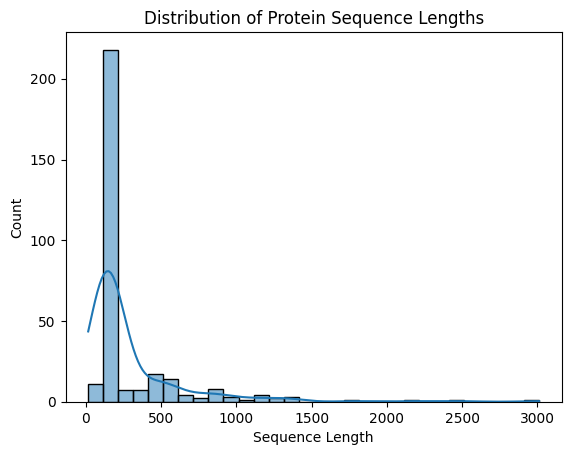

In [133]:
sns.histplot(data['length'], bins=30, kde=True)
plt.title("Distribution of Protein Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.show()


#Step 4 : ProtBert Embeddings

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [135]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = AutoModel.from_pretrained("Rostlab/prot_bert")
model = model.to(device)
model = model.eval()

Loading weights:   0%|          | 0/487 [00:00<?, ?it/s]

BertModel LOAD REPORT from: Rostlab/prot_bert
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [136]:
def emb_sequence(seq):
  seq = " ".join(list(seq)) #add space between amino acids
  inputs = tokenizer(seq, return_tensors="pt")
  inputs = {key: value.to(device) for key, value in inputs.items()} #move inputs to GPU

  with torch.no_grad(): #no need for traning just used it for prediciton
    outputs = model(**inputs)
  embedding = outputs.last_hidden_state.mean(dim=1) #average pooling
  return embedding.squeeze().cpu().numpy()



In [137]:
embeddings = []
for seq in data['sequence']:
  emb = emb_sequence(seq)
  embeddings.append(emb)


In [138]:
embeddings_matrix = np.vstack(embeddings) #convert into 2D matrix
print("Embedding matrix shape:", embeddings_matrix.shape)

Embedding matrix shape: (305, 1024)


# Step 5: Dimensionality Reduction

In [139]:

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings_matrix)

tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_matrix)


# Step 6: K-means Clustering


In [140]:

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings_matrix)


# Step 7: Visualization

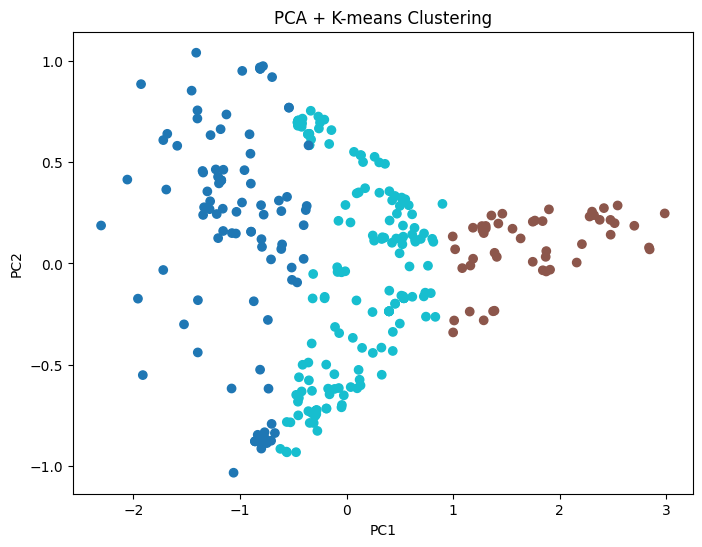

In [142]:
# PCA plot colored by K-means cluster
plt.figure(figsize=(8,6))
plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1], c=clusters, cmap='tab10')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA + K-means Clustering")
plt.show()

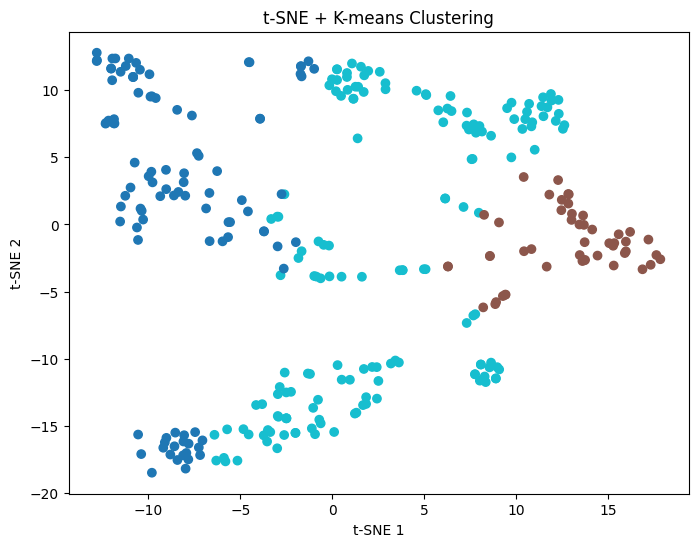

In [143]:

# t-SNE plot colored by K-means cluster
plt.figure(figsize=(8,6))
plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c=clusters, cmap='tab10')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE + K-means Clustering")
plt.show()

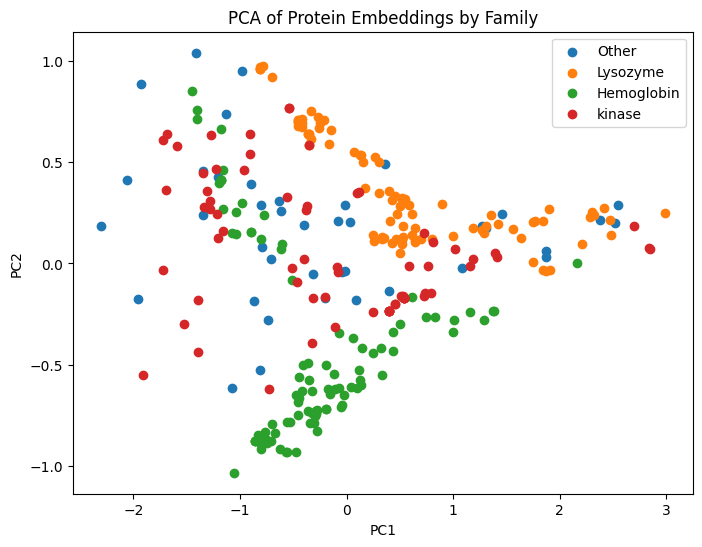

In [144]:
# PCA plot colored by true family
plt.figure(figsize=(8,6))
for fam in data['family'].unique():
    idx = data['family'] == fam
    plt.scatter(pca_embeddings[idx,0], pca_embeddings[idx,1], label=fam)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Protein Embeddings by Family")
plt.legend()
plt.show()

# Step 8: Simple Evaluation

In [152]:
true_labels = data['family'].values
# Map cluster number to most frequent family in that cluster
cluster_to_family = {}
for cluster in np.unique(clusters):
    idx = np.where(clusters == cluster)[0]
    most_common_family = np.bincount([np.where(data['family'].unique() == true_labels[i])[0][0] for i in idx]).argmax()
    cluster_to_family[cluster] = data['family'].unique()[most_common_family]

pred_labels = np.array([cluster_to_family[c] for c in clusters])

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=data['family'].unique())
print("Confusion Matrix:\n", cm)

# Classification report
print("Classification Report:\n", classification_report(true_labels, pred_labels))

# Simple accuracy
accuracy = np.mean(pred_labels == true_labels)
print("K-means clustering accuracy:", accuracy)

Confusion Matrix:
 [[ 0 19 21  0]
 [ 0 86  6  0]
 [ 0 63 40  0]
 [ 0 38 32  0]]
Classification Report:
               precision    recall  f1-score   support

  Hemoglobin       0.40      0.39      0.40       103
    Lysozyme       0.42      0.93      0.58        92
       Other       0.00      0.00      0.00        40
      kinase       0.00      0.00      0.00        70

    accuracy                           0.41       305
   macro avg       0.21      0.33      0.24       305
weighted avg       0.26      0.41      0.31       305

K-means clustering accuracy: 0.4131147540983607


In [153]:
# Mask out 'Other'

mask = data['family'] != 'Other'
true_labels_simple = data['family'][mask].values
clusters_simple = clusters[mask]

# Map cluster number to most frequent family in that cluster

cluster_to_family = {}
for cluster in np.unique(clusters_simple):
    idx = np.where(clusters_simple == cluster)[0]
    # find most common family in this cluster
    most_common_family = np.bincount([np.where(np.unique(true_labels_simple) == true_labels_simple[i])[0][0] for i in idx]).argmax()
    cluster_to_family[cluster] = np.unique(true_labels_simple)[most_common_family]

# Predicted labels for masked data
pred_labels_simple = np.array([cluster_to_family[c] for c in clusters_simple])

# Confusion matrix and classification report

cm = confusion_matrix(true_labels_simple, pred_labels_simple, labels=np.unique(true_labels_simple))
print("Confusion Matrix (without 'Other'):\n", cm)

print("Classification Report (without 'Other'):\n", classification_report(true_labels_simple, pred_labels_simple))

# Simple accuracy
accuracy = np.mean(pred_labels_simple == true_labels_simple)
print("K-means clustering accuracy (without 'Other'):", accuracy)


Confusion Matrix (without 'Other'):
 [[40 63  0]
 [ 6 86  0]
 [32 38  0]]
Classification Report (without 'Other'):
               precision    recall  f1-score   support

  Hemoglobin       0.51      0.39      0.44       103
    Lysozyme       0.46      0.93      0.62        92
      kinase       0.00      0.00      0.00        70

    accuracy                           0.48       265
   macro avg       0.32      0.44      0.35       265
weighted avg       0.36      0.48      0.39       265

K-means clustering accuracy (without 'Other'): 0.47547169811320755
